# 提取日期

如按自然日处理，最终统计的是2017到2024都为交易日的日期

In [ ]:
import pandas as pd
import pandas_market_calendars as pmc

# 1) 交易日历
sh = pmc.get_calendar('XSHG')
schedule = sh.schedule(start_date='2017-01-01', end_date='2025-12-31')
trade_days = schedule.index.normalize()         # DatetimeIndex（日期级）
trade_days_set = set(trade_days)                # O(1) 查询

# 2) 原始数据 -> 按年字典，并把 date 设为索引
df_raw = pd.read_excel('中债国债到期收益率_10年.xlsx')
df_raw['date'] = pd.to_datetime(df_raw['date']).dt.normalize()
df_raw = df_raw.sort_values('date')

df_by_year = {
    y: g.set_index('date').sort_index()
    for y, g in df_raw.groupby(df_raw['date'].dt.year)
}

# 可选：在原 df 上标注是否交易日
df_raw['is_trade_day'] = df_raw['date'].isin(trade_days)

In [ ]:
# 3) 非交易日对齐（选用“对齐到下一个交易日”；你也可以改成上一个：method='pad'）
def align_to_next_trade_day(ts: pd.Timestamp, trade_idx: pd.DatetimeIndex):
    ts = pd.Timestamp(ts).normalize()
    pos = trade_idx.searchsorted(ts)  # >= ts 的第一个交易日位置
    if pos >= len(trade_idx):
        return None
    return trade_idx[pos]

# 4) 计算收益
def calculate_profit(df_by_year: dict, start_date: pd.Timestamp, end_date: pd.Timestamp,
                     trade_idx: pd.DatetimeIndex, strict=False):
    # 标准化
    start_date = pd.Timestamp(start_date).normalize()
    end_date = pd.Timestamp(end_date).normalize()

    if strict:
        # 严格要求当天必须是交易日
        if (start_date not in trade_days_set) or (end_date not in trade_days_set):
            return None, None
    else:
        # 自动对齐到最近的“下一个”交易日（也可改成上一个）
        start_date = align_to_next_trade_day(start_date, trade_idx)
        end_date = align_to_next_trade_day(end_date, trade_idx)
        if (start_date is None) or (end_date is None):
            return None, None

    try:
        s = df_by_year[start_date.year].loc[start_date, 'yield']
        e = df_by_year[end_date.year].loc[end_date, 'yield']
    except KeyError:
        # 某年的该交易日数据里缺失（比如债券收益率缺一行）
        return None, None

    return float(e - s), int((end_date - start_date).days)

# 5) 获取结束日期
def get_end_date(start_date:pd.Timestamp, length:int) -> pd.Timestamp:
    """获取从 start_date 开始，长度为 length 天的结束日期"""
    start_date = pd.Timestamp(start_date).normalize()
    return start_date + pd.Timedelta(days=length)

# 6) 获取2017-2024的同日
def get_same_day_in_years(start_date: pd.Timestamp) -> list:
    """获取 start_date 在指定年份的同日"""
    years = [2017,2018,2019,2020,2021,2022,2023,2024]
    start_date = pd.Timestamp(start_date).normalize()
    return [pd.Timestamp(f"{y}-{start_date.month:02d}-{start_date.day:02d}") for y in years]

# 7) 主脚本
seq_length = [3, 10, 15, 30, 60, 90]
for length in seq_length:
    print(f"Length: {length} days")
    for start_date in get_same_day_in_years('2017-01-01'):
        end_date = get_end_date(start_date, length)
        profit, days = calculate_profit(df_by_year, start_date, end_date, trade_days, strict=False)
        if profit is not None:
            print(f"From {start_date.date()} to {end_date.date()}: Profit={profit:.2f}, Days={days}")
        else:
            print(f"From {start_date.date()} to {end_date.date()}: No data available")

In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
import pandas_market_calendars as pmc

# ========= 0) 读数据 & 交易日历 =========
DATA_FILE = '中债国债到期收益率_10年.xlsx'   # 两列：date, yield

df_raw = pd.read_excel(DATA_FILE)
df_raw['date'] = pd.to_datetime(df_raw['date']).dt.normalize()
df_raw = df_raw.sort_values('date')

# 按年分表，并把 date 设为索引
df_by_year = {
    y: g.set_index('date').sort_index()
    for y, g in df_raw.groupby(df_raw['date'].dt.year)
}

# 交易日历（XSHG；如需银行间可替换为自建日历）
cal = pmc.get_calendar('XSHG')
trade_idx = cal.schedule(start_date='2017-01-01', end_date='2025-12-31').index.normalize()
trade_idx = pd.DatetimeIndex(trade_idx)      # 保证是 DatetimeIndex
trade_set = set(trade_idx)                   # O(1) 查询

# ========= 1) 工具函数 =========
def align_to_next_trade_day(ts: pd.Timestamp, trade_idx: pd.DatetimeIndex):
    """对齐到 >= ts 的最近交易日；超出范围返回 None"""
    ts = pd.Timestamp(ts).normalize()
    pos = trade_idx.searchsorted(ts)
    if pos >= len(trade_idx):
        return None
    return trade_idx[pos]

def safe_make_date(year: int, month: int, day: int):
    """处理 2/29 等无效日期，返回 None 表示该年无此日期"""
    try:
        return pd.Timestamp(year=year, month=month, day=day)
    except ValueError:
        return None

def window_profit_one_year(y: int, start_md: tuple[int,int], length: int,
                           trade_idx: pd.DatetimeIndex):
    """
    给定某一年 y、起点“月日” start_md=(m,d) 和持有天数 length，
    计算该年的收益（自动对齐到下一个交易日）。返回 (profit, s_aligned, e_aligned)；若缺数据则 profit=None。
    """
    m, d = start_md
    s0 = safe_make_date(y, m, d)
    if s0 is None:
        return None, None, None

    e0 = s0 + pd.Timedelta(days=length)

    s = align_to_next_trade_day(s0, trade_idx)
    e = align_to_next_trade_day(e0, trade_idx)
    if (s is None) or (e is None):
        return None, None, None

    # 两端必须在各自年份的表中存在
    try:
        s_val = df_by_year[s.year].loc[s, 'yield']
        e_val = df_by_year[e.year].loc[e, 'yield']  # 可能跨年
    except KeyError:
        return None, None, None
    # 做多或做空时改这里
    return float(s_val - e_val), s, e

def window_profit_multi_years(start_2017: pd.Timestamp, length: int,
                              years: list[int], trade_idx: pd.DatetimeIndex):
    """
    固定 2017 的某个起点（决定 month/day），在给定 years 列表中逐年复用“同月日 + 同 length”，
    计算可用年份的累计收益与使用年数，并记录每年对齐后的 (s,e) 以备落盘。
    """
    md = (pd.Timestamp(start_2017).month, pd.Timestamp(start_2017).day)
    total = 0.0
    used = 0
    path = []   # list[(year, s_aligned, e_aligned, profit)]
    for y in years:
        p, s, e = window_profit_one_year(y, md, length, trade_idx)
        if p is not None:
            total += p
            used += 1
            path.append((y, s, e, p))
    return (total if used > 0 else None), used, path

# ========= 2) 主流程：对 2017 年所有“日历日”遍历并保存 Top-10 与路径 =========
years_pool = list(range(2017, 2025))   # 2017–2024
seq_lengths = list(range(30, 90, 10))  # 30–90 天

# 用“日历日”更全面（非交易日会自动对齐）
all_2017_days = pd.date_range('2017-01-01', '2017-12-31', freq='D')

out_dir = Path('top10_windows_by_length')
out_dir.mkdir(parents=True, exist_ok=True)

for L in seq_lengths:
    rows = []
    detail_paths = []  # 收集 Top-10 的逐年轨迹（稍后填充）

    # 1) 全量候选起点评估
    for start in all_2017_days:
        total_profit, used_years, path = window_profit_multi_years(start, L, years_pool, trade_idx)
        if total_profit is None:
            continue
        end2017 = start + pd.Timedelta(days=L)
        rows.append({
            'length_days': L,
            'start_2017': start.date(),
            'end_2017': end2017.date(),
            'total_profit': total_profit,
            'avg_profit_per_year': total_profit / used_years if used_years > 0 else np.nan,
            'years_used': used_years
        })

    if not rows:
        print(f'[Length={L}] 没有可用窗口。')
        continue

    # 2) 排名&保存 Top-10
    df_rank = pd.DataFrame(rows).sort_values(['total_profit', 'years_used'], ascending=[False, False])
    top10 = df_rank.head(10).reset_index(drop=True)
    top_path = out_dir / f'top10_len_{L}.xlsx'
    top10.to_excel(top_path, index=False)
    print(f'[Length={L}] 已保存 Top-10 到: {top_path}')

    # 3) 基于 Top-10 重新计算逐年轨迹并保存 paths_len_{L}.xlsx
    for _, row in top10.iterrows():
        start_2017 = pd.Timestamp(row['start_2017'])
        total_profit, used_years, path = window_profit_multi_years(start_2017, L, years_pool, trade_idx)
        for (y, s, e, p) in path:
            detail_paths.append({
                'length_days': L,
                'start_2017': start_2017.date(),
                'year': y,
                'start_aligned': s.date() if s is not None else None,
                'end_aligned': e.date() if e is not None else None,
                'profit': p
            })

    paths_path = out_dir / f'paths_len_{L}.xlsx'
    pd.DataFrame(detail_paths).to_excel(paths_path, index=False)
    print(f'[Length={L}] 已保存逐年轨迹到: {paths_path}')

    # （可选）保存所有候选窗口的完整排行榜，便于热力图或后续分析
    # all_path = out_dir / f'all_windows_len_{L}.xlsx'
    # df_rank.to_excel(all_path, index=False)
    # print(f'[Length={L}] 已保存完整排行榜到: {all_path}')

[Length=30] 已保存 Top-10 到: top10_windows_by_length\top10_len_30.xlsx
[Length=30] 已保存逐年轨迹到: top10_windows_by_length\paths_len_30.xlsx
[Length=40] 已保存 Top-10 到: top10_windows_by_length\top10_len_40.xlsx
[Length=40] 已保存逐年轨迹到: top10_windows_by_length\paths_len_40.xlsx
[Length=50] 已保存 Top-10 到: top10_windows_by_length\top10_len_50.xlsx
[Length=50] 已保存逐年轨迹到: top10_windows_by_length\paths_len_50.xlsx
[Length=60] 已保存 Top-10 到: top10_windows_by_length\top10_len_60.xlsx
[Length=60] 已保存逐年轨迹到: top10_windows_by_length\paths_len_60.xlsx
[Length=70] 已保存 Top-10 到: top10_windows_by_length\top10_len_70.xlsx
[Length=70] 已保存逐年轨迹到: top10_windows_by_length\paths_len_70.xlsx
[Length=80] 已保存 Top-10 到: top10_windows_by_length\top10_len_80.xlsx
[Length=80] 已保存逐年轨迹到: top10_windows_by_length\paths_len_80.xlsx


# RUN

In [17]:
import pandas as pd
import numpy as np
from pathlib import Path
import pandas_market_calendars as pmc

# ========= 可配置：做多/做空 & 月日范围/排除区间 =========
DO_LONG = True  # True=做多（收益率下降赚钱），False=做空（收益率上升赚钱）

# 只研究每年 [02-01, 10-15] 之间的起点（含端点）；若不需要限制，设为 None
ALLOWED_START_MD_RANGE = None#((2, 1), (10, 15))    # (month, day), (month, day)

# 排除的月日区间列表：例如五一假期 [05-01, 05-07]，中秋 [09-15, 09-17] 等
# 若不需要排除，设为空列表 []
EXCLUDE_MD_RANGES = []         # 可多段：[((m1,d1),(m2,d2)), ...]
REQUIRE_END_IN_ALLOWED = True                 # 是否要求平仓月日也落在允许范围内
DISALLOW_CROSS_YEAR = True  # 不允许跨年窗口

# ========= 0) 读数据 & 交易日历 =========
DATA_FILE = '中债国债到期收益率_10年.xlsx'   # 两列：date, yield

df_raw = pd.read_excel(DATA_FILE)
df_raw['date'] = pd.to_datetime(df_raw['date']).dt.normalize()
df_raw = df_raw.sort_values('date')

# 按年分表，并把 date 设为索引
df_by_year = {
    y: g.set_index('date').sort_index()
    for y, g in df_raw.groupby(df_raw['date'].dt.year)
}

# 交易日历（XSHG；如需银行间可替换为自建日历）
cal = pmc.get_calendar('XSHG')
trade_idx = cal.schedule(start_date='2017-01-01', end_date='2023-12-31').index.normalize()
trade_idx = pd.DatetimeIndex(trade_idx)      # 保证是 DatetimeIndex
trade_set = set(trade_idx)                   # O(1) 查询

# ========= 1) 工具函数 =========
def align_to_next_trade_day(ts: pd.Timestamp, trade_idx: pd.DatetimeIndex):
    """对齐到 >= ts 的最近交易日；超出范围返回 None"""
    ts = pd.Timestamp(ts).normalize()
    pos = trade_idx.searchsorted(ts)
    if pos >= len(trade_idx):
        return None
    return trade_idx[pos]

def safe_make_date(year: int, month: int, day: int):
    """处理 2/29 等无效日期，返回 None 表示该年无此日期"""
    try:
        return pd.Timestamp(year=year, month=month, day=day)
    except ValueError:
        return None

def md_in_range(md, lo, hi):
    """判断月日 md=(m,d) 是否在 [lo, hi] 闭区间；支持跨年（如 11-01 到 02-15）。"""
    (m,d) = md; (m1,d1) = lo; (m2,d2) = hi
    if (m1, d1) <= (m2, d2):   # 不跨年
        return (m,d) >= (m1,d1) and (m,d) <= (m2,d2)
    else:                      # 跨年（如 11-01..02-15）
        return (m,d) >= (m1,d1) or  (m,d) <= (m2,d2)

def interval_overlap_md(a_lo, a_hi, b_lo, b_hi):
    """判断两个月日区间 [a_lo, a_hi] 与 [b_lo, b_hi] 是否在折叠日历上有重叠（均支持跨年）。"""
    # 把月日映射到“虚拟非闰年”的 day-of-year，便于统一处理
    def md_to_doy(md):
        y = 2001  # 非闰年
        return (pd.Timestamp(year=y, month=md[0], day=md[1]) - pd.Timestamp(year=y, month=1, day=1)).days + 1
    def to_segments(lo, hi):
        s, e = md_to_doy(lo), md_to_doy(hi)
        if s <= e:  # 不跨年
            return [(s, e)]
        else:       # 跨年拆成两段
            return [(s, 365), (1, e)]
    segA = to_segments(a_lo, a_hi)
    segB = to_segments(b_lo, b_hi)
    # 任意一对段有交集即重叠
    for s1, e1 in segA:
        for s2, e2 in segB:
            if not (e1 < s2 or e2 < s1):
                return True
    return False

def window_profit_one_year(y: int, start_md: tuple[int,int], length: int,
                           trade_idx: pd.DatetimeIndex):
    m, d = start_md
    # 1) 起点是否在允许范围
    if ALLOWED_START_MD_RANGE is not None:
        if not md_in_range((m, d), ALLOWED_START_MD_RANGE[0], ALLOWED_START_MD_RANGE[1]):
            return None, None, None

    s0 = safe_make_date(y, m, d)
    if s0 is None:
        return None, None, None

    e0 = s0 + pd.Timedelta(days=length)

    # --- 预检查：按日历天是否跨年 ---
    if DISALLOW_CROSS_YEAR and (e0.year != s0.year):
        return None, None, None

    # 2) 对齐到交易日
    s = align_to_next_trade_day(s0, trade_idx)
    e = align_to_next_trade_day(e0, trade_idx)
    if (s is None) or (e is None):
        return None, None, None

    # --- 对齐后复检：若对齐把窗口推到了次年，也跳过 ---
    if DISALLOW_CROSS_YEAR and (e.year != s.year):
        return None, None, None

    # 3) 平仓月日是否也要求在允许范围内
    if REQUIRE_END_IN_ALLOWED and (ALLOWED_START_MD_RANGE is not None):
        if not md_in_range((e.month, e.day), ALLOWED_START_MD_RANGE[0], ALLOWED_START_MD_RANGE[1]):
            return None, None, None

    # 4) 排除区间重叠检查
    if EXCLUDE_MD_RANGES:
        win_lo = (s.month, s.day)
        win_hi = (e.month, e.day)
        for ex_lo, ex_hi in EXCLUDE_MD_RANGES:
            if interval_overlap_md(win_lo, win_hi, ex_lo, ex_hi):
                return None, None, None

    # 5) 计算收益（做多/做空）
    try:
        s_val = df_by_year[s.year].loc[s, 'yield']
        e_val = df_by_year[e.year].loc[e, 'yield']
    except KeyError:
        return None, None, None

    profit = (s_val - e_val) if DO_LONG else (e_val - s_val)
    return float(profit), s, e


def window_profit_multi_years(start_2017: pd.Timestamp, length: int,
                              years: list[int], trade_idx: pd.DatetimeIndex):
    """
    固定 2017 的某个起点（决定 month/day），在给定 years 列表中逐年复用“同月日 + 同 length”，
    计算可用年份的累计收益与使用年数，并记录每年对齐后的 (s,e) 以备落盘。
    """
    md = (pd.Timestamp(start_2017).month, pd.Timestamp(start_2017).day)
    total = 0.0
    used = 0
    path = []   # list[(year, s_aligned, e_aligned, profit)]
    for y in years:
        p, s, e = window_profit_one_year(y, md, length, trade_idx)
        if p is not None:
            total += p
            used += 1
            path.append((y, s, e, p))
    return (total if used > 0 else None), used, path

# ========= 2) 主流程：对 2017 年所有“日历日”遍历并保存 Top-10 与路径 =========
years_pool = list(range(2017, 2025))   # 2017–2024
seq_lengths = list(range(15, 90, 5))  # 15–90 天

# 用“日历日”更全面（非交易日会自动对齐）；但先按 ALLOWED_START_MD_RANGE 预筛
all_2017_days = pd.date_range('2017-01-01', '2017-12-31', freq='D')
if ALLOWED_START_MD_RANGE is not None:
    lo, hi = ALLOWED_START_MD_RANGE
    all_2017_days = [d for d in all_2017_days if md_in_range((d.month, d.day), lo, hi)]

out_dir = Path('top10_windows_by_length')
out_dir.mkdir(parents=True, exist_ok=True)

for L in seq_lengths:
    rows = []
    detail_paths = []  # 收集 Top-10 的逐年轨迹（稍后填充）

    # 1) 全量候选起点评估（已按 ALLOWED_START_MD_RANGE 预筛）
    for start in all_2017_days:
        total_profit, used_years, path = window_profit_multi_years(start, L, years_pool, trade_idx)
        if total_profit is None:
            continue
        end2017 = start + pd.Timedelta(days=L)
        rows.append({
            'length_days': L,
            'start_2017': start.date(),
            'end_2017': end2017.date(),
            'total_profit': total_profit,
            'avg_profit_per_year': total_profit / used_years if used_years > 0 else np.nan,
            'years_used': used_years
        })

    if not rows:
        print(f'[Length={L}] 指定条件下没有可用窗口。')
        continue

    # 2) 排名&保存 Top-10（越大越好；做多/做空已在 profit 定义中体现）
    df_rank = pd.DataFrame(rows).sort_values(['avg_profit_per_year', 'years_used'], ascending=[False, False])
    top10 = df_rank.head(10).reset_index(drop=True)
    top_path = out_dir / f'top10_len_{L}.xlsx'
    top10.to_excel(top_path, index=False)
    print(f'[Length={L}] 已保存 Top-10 到: {top_path}')

    # 3) 基于 Top-10 重新计算逐年轨迹并保存 paths_len_{L}.xlsx
    for _, row in top10.iterrows():
        start_2017 = pd.Timestamp(row['start_2017'])
        total_profit, used_years, path = window_profit_multi_years(start_2017, L, years_pool, trade_idx)
        for (y, s, e, p) in path:
            detail_paths.append({
                'length_days': L,
                'start_2017': start_2017.date(),
                'year': y,
                'start_aligned': s.date() if s is not None else None,
                'end_aligned': e.date() if e is not None else None,
                'profit': p
            })

    paths_path = out_dir / f'paths_len_{L}.xlsx'
    pd.DataFrame(detail_paths).to_excel(paths_path, index=False)
    print(f'[Length={L}] 已保存逐年轨迹到: {paths_path}')

[Length=15] 已保存 Top-10 到: top10_windows_by_length\top10_len_15.xlsx
[Length=15] 已保存逐年轨迹到: top10_windows_by_length\paths_len_15.xlsx
[Length=20] 已保存 Top-10 到: top10_windows_by_length\top10_len_20.xlsx
[Length=20] 已保存逐年轨迹到: top10_windows_by_length\paths_len_20.xlsx
[Length=25] 已保存 Top-10 到: top10_windows_by_length\top10_len_25.xlsx
[Length=25] 已保存逐年轨迹到: top10_windows_by_length\paths_len_25.xlsx
[Length=30] 已保存 Top-10 到: top10_windows_by_length\top10_len_30.xlsx
[Length=30] 已保存逐年轨迹到: top10_windows_by_length\paths_len_30.xlsx
[Length=35] 已保存 Top-10 到: top10_windows_by_length\top10_len_35.xlsx
[Length=35] 已保存逐年轨迹到: top10_windows_by_length\paths_len_35.xlsx
[Length=40] 已保存 Top-10 到: top10_windows_by_length\top10_len_40.xlsx
[Length=40] 已保存逐年轨迹到: top10_windows_by_length\paths_len_40.xlsx
[Length=45] 已保存 Top-10 到: top10_windows_by_length\top10_len_45.xlsx
[Length=45] 已保存逐年轨迹到: top10_windows_by_length\paths_len_45.xlsx
[Length=50] 已保存 Top-10 到: top10_windows_by_length\top10_len_50.xlsx
[Length=

# NEW RUN

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import pandas_market_calendars as pmc

# ========= 可配置：做多/做空 & 月日范围/排除区间 =========
DO_LONG = True  # True=做多（收益率下降赚钱），False=做空（收益率上升赚钱）

# 只研究每年 [MM-DD, MM-DD] 之间的“起点”（含端点）；不限制则设为 None
ALLOWED_START_MD_RANGE = None  # 例如：((2, 1), (10, 15))

# 排除的月日区间列表（同一年折叠口径，支持跨年表示）
# 例如：[( (5,1),(5,7) ), ( (9,15),(9,17) )]
EXCLUDE_MD_RANGES = []

# 平仓月日也要求落在 ALLOWED_START_MD_RANGE 内（仅当上面不为 None 时生效）
REQUIRE_END_IN_ALLOWED = True

# 不允许跨年窗口：起点+length 若跨到下一年，直接跳过（对齐后也复检）
DISALLOW_CROSS_YEAR = True

# ========= 0) 读数据 & 交易日历 =========
DATA_FILE = '中债国债到期收益率_10年.xlsx'   # 需包含两列：date, yield

df_raw = pd.read_excel(DATA_FILE)
df_raw['date'] = pd.to_datetime(df_raw['date']).dt.normalize()
df_raw = df_raw.sort_values('date')

# 按年分表，并把 date 设为索引
df_by_year = {
    y: g.set_index('date').sort_index()
    for y, g in df_raw.groupby(df_raw['date'].dt.year)
}

# 交易日历（XSHG；如需银行间可替换为自建日历/表）
cal = pmc.get_calendar('XSHG')
# 根据你的 years_pool 设置覆盖范围
trade_idx = cal.schedule(start_date='2017-01-01', end_date='2023-12-31').index.normalize()
trade_idx = pd.DatetimeIndex(trade_idx)      # 保证是 DatetimeIndex
trade_set = set(trade_idx)                   # O(1) 查询

# ========= 1) 工具函数 =========
def align_to_next_trade_day(ts: pd.Timestamp, trade_idx: pd.DatetimeIndex):
    """对齐到 >= ts 的最近交易日；超出范围返回 None"""
    ts = pd.Timestamp(ts).normalize()
    pos = trade_idx.searchsorted(ts)
    if pos >= len(trade_idx):
        return None
    return trade_idx[pos]

def safe_make_date(year: int, month: int, day: int):
    """处理 2/29 等无效日期，返回 None 表示该年无此日期"""
    try:
        return pd.Timestamp(year=year, month=month, day=day)
    except ValueError:
        return None

def md_in_range(md, lo, hi):
    """判断月日 md=(m,d) 是否在 [lo, hi] 闭区间；支持跨年（如 11-01..02-15）。"""
    (m,d) = md; (m1,d1) = lo; (m2,d2) = hi
    if (m1, d1) <= (m2, d2):   # 不跨年
        return (m,d) >= (m1,d1) and (m,d) <= (m2,d2)
    else:                      # 跨年（例如 11-01..02-15）
        return (m,d) >= (m1,d1) or  (m,d) <= (m2,d2)

def interval_overlap_md(a_lo, a_hi, b_lo, b_hi):
    """判断两个月日区间 [a_lo, a_hi] 与 [b_lo, b_hi] 是否在折叠日历上有重叠（均支持跨年）。"""
    def md_to_doy(md):
        y = 2001  # 非闰年
        return (pd.Timestamp(year=y, month=md[0], day=md[1]) - pd.Timestamp(year=y, month=1, day=1)).days + 1
    def to_segments(lo, hi):
        s, e = md_to_doy(lo), md_to_doy(hi)
        if s <= e:  # 不跨年
            return [(s, e)]
        else:       # 跨年拆段
            return [(s, 365), (1, e)]
    segA = to_segments(a_lo, a_hi)
    segB = to_segments(b_lo, b_hi)
    for s1, e1 in segA:
        for s2, e2 in segB:
            if not (e1 < s2 or e2 < s1):
                return True
    return False

def window_profit_one_year(y: int, start_md: tuple[int,int], length: int,
                           trade_idx: pd.DatetimeIndex):
    """计算给定年份的一段窗口收益；按配置过滤范围/排除段/跨年等。"""
    m, d = start_md

    # 1) 起点是否在允许范围
    if ALLOWED_START_MD_RANGE is not None:
        if not md_in_range((m, d), ALLOWED_START_MD_RANGE[0], ALLOWED_START_MD_RANGE[1]):
            return None, None, None

    s0 = safe_make_date(y, m, d)
    if s0 is None:
        return None, None, None

    e0 = s0 + pd.Timedelta(days=length)

    # --- 预检查：按日历天是否跨年 ---
    if DISALLOW_CROSS_YEAR and (e0.year != s0.year):
        return None, None, None

    # 2) 对齐到交易日
    s = align_to_next_trade_day(s0, trade_idx)
    e = align_to_next_trade_day(e0, trade_idx)
    if (s is None) or (e is None):
        return None, None, None

    # --- 对齐后复检：若对齐把窗口推到了次年，也跳过 ---
    if DISALLOW_CROSS_YEAR and (e.year != s.year):
        return None, None, None

    # 3) 平仓月日也要求在允许范围（可选）
    if REQUIRE_END_IN_ALLOWED and (ALLOWED_START_MD_RANGE is not None):
        if not md_in_range((e.month, e.day), ALLOWED_START_MD_RANGE[0], ALLOWED_START_MD_RANGE[1]):
            return None, None, None

    # 4) 排除区间重叠检查
    if EXCLUDE_MD_RANGES:
        win_lo = (s.month, s.day)
        win_hi = (e.month, e.day)
        for ex_lo, ex_hi in EXCLUDE_MD_RANGES:
            if interval_overlap_md(win_lo, win_hi, ex_lo, ex_hi):
                return None, None, None

    # 5) 计算收益（做多/做空）
    try:
        s_val = df_by_year[s.year].loc[s, 'yield']
        e_val = df_by_year[e.year].loc[e, 'yield']
    except KeyError:
        return None, None, None

    profit = (s_val - e_val) if DO_LONG else (e_val - s_val)
    return float(profit), s, e

def window_profit_multi_years(start_2017: pd.Timestamp, length: int,
                              years: list[int], trade_idx: pd.DatetimeIndex):
    """固定 2017 的某个起点（月日+length），逐年复制，汇总收益与轨迹。"""
    md = (pd.Timestamp(start_2017).month, pd.Timestamp(start_2017).day)
    total = 0.0
    used = 0
    path = []   # list[(year, s_aligned, e_aligned, profit)]
    for y in years:
        p, s, e = window_profit_one_year(y, md, length, trade_idx)
        if p is not None:
            total += p
            used += 1
            path.append((y, s, e, p))
    return (total if used > 0 else None), used, path

# ========= 2) 主流程 =========
years_pool  = list(range(2017, 2024))      # 2017–2024
seq_lengths = list(range(30, 90, 5))       # 15–90 天，步长 5

# 候选起点（2017 全年），若限定月日范围则先预筛
all_2017_days = pd.date_range('2017-01-01', '2017-12-31', freq='D')
if ALLOWED_START_MD_RANGE is not None:
    lo, hi = ALLOWED_START_MD_RANGE
    all_2017_days = [d for d in all_2017_days if md_in_range((d.month, d.day), lo, hi)]

out_dir = Path('top10_windows_by_length')
out_dir.mkdir(parents=True, exist_ok=True)

# 全局收集，用于所有 length 合并后的“日均收益率榜”
global_rows = []

for L in seq_lengths:
    rows = []
    detail_paths = []

    for start in all_2017_days:
        # 针对该 L 的“日历快速剪枝”：若起点+length 跨年且禁止跨年，则跳过
        if DISALLOW_CROSS_YEAR and (start + pd.Timedelta(days=L)).year != start.year:
            continue

        total_profit, used_years, path = window_profit_multi_years(start, L, years_pool, trade_idx)
        if total_profit is None:
            continue
        end2017 = start + pd.Timedelta(days=L)
        rows.append({
            'length_days': L,
            'start_2017': start.date(),
            'end_2017': end2017.date(),
            'total_profit': total_profit,
            'avg_profit_per_year': total_profit / used_years if used_years > 5 else np.nan,
            'years_used': used_years
        })

    if not rows:
        print(f'[Length={L}] 指定条件下没有可用窗口。')
        continue

    # ——把本 length 的 rows 扩展出“日均收益率”并并入全局——
    for r in rows:
        L_cur = r['length_days']
        used  = r['years_used']
        r['avg_daily'] = (r['total_profit'] / (L_cur * used)) if used > 5 else np.nan
    global_rows.extend(rows)

    # 2) 排名&保存 Top-10（本 length 内，按 avg_profit_per_year 优先）
    df_rank = pd.DataFrame(rows).sort_values(
        ['avg_profit_per_year', 'years_used', 'total_profit'],
        ascending=[False, False, False]
    )
    top10 = df_rank.head(10).reset_index(drop=True)
    top_path = out_dir / f'top10_len_{L}.xlsx'
    top10.to_excel(top_path, index=False)
    print(f'[Length={L}] 已保存 Top-10 到: {top_path}')

    # 3) 基于 Top-10 重新计算逐年轨迹并保存 paths_len_{L}.xlsx
    for _, row in top10.iterrows():
        start_2017 = pd.Timestamp(row['start_2017'])
        _, _, path = window_profit_multi_years(start_2017, L, years_pool, trade_idx)
        for (y, s, e, p) in path:
            detail_paths.append({
                'length_days': L,
                'start_2017': start_2017.date(),
                'year': y,
                'start_aligned': s.date() if s is not None else None,
                'end_aligned': e.date() if e is not None else None,
                'profit': p
            })

    paths_path = out_dir / f'paths_len_{L}.xlsx'
    pd.DataFrame(detail_paths).to_excel(paths_path, index=False)
    print(f'[Length={L}] 已保存逐年轨迹到: {paths_path}')

# ========= 3) 生成“所有 length 合并”的日均收益率总榜 =========
if global_rows:
    df_all = pd.DataFrame(global_rows)
    df_all_rank = df_all.sort_values(
        ['avg_daily', 'years_used', 'total_profit'],
        ascending=[False, False, False]
    ).reset_index(drop=True)

    all_rank_path   = out_dir / 'all_lengths_rank_by_avg_daily.xlsx'
    df_all_rank.to_excel(all_rank_path, index=False)
    print(f'[ALL] 已保存“所有 length 合并后的日均收益率排行榜”到: {all_rank_path}')

    all_top100_path = out_dir / 'all_lengths_top100_by_avg_daily.xlsx'
    df_all_rank.head(100).to_excel(all_top100_path, index=False)
    print(f'[ALL] 已保存 Top-100 到: {all_top100_path}')
else:
    print('[ALL] 没有可用窗口，未生成总榜。')

[Length=30] 已保存 Top-10 到: top10_windows_by_length\top10_len_30.xlsx
[Length=30] 已保存逐年轨迹到: top10_windows_by_length\paths_len_30.xlsx
[Length=35] 已保存 Top-10 到: top10_windows_by_length\top10_len_35.xlsx
[Length=35] 已保存逐年轨迹到: top10_windows_by_length\paths_len_35.xlsx
[Length=40] 已保存 Top-10 到: top10_windows_by_length\top10_len_40.xlsx
[Length=40] 已保存逐年轨迹到: top10_windows_by_length\paths_len_40.xlsx
[Length=45] 已保存 Top-10 到: top10_windows_by_length\top10_len_45.xlsx
[Length=45] 已保存逐年轨迹到: top10_windows_by_length\paths_len_45.xlsx
[Length=50] 已保存 Top-10 到: top10_windows_by_length\top10_len_50.xlsx
[Length=50] 已保存逐年轨迹到: top10_windows_by_length\paths_len_50.xlsx
[Length=55] 已保存 Top-10 到: top10_windows_by_length\top10_len_55.xlsx
[Length=55] 已保存逐年轨迹到: top10_windows_by_length\paths_len_55.xlsx
[Length=60] 已保存 Top-10 到: top10_windows_by_length\top10_len_60.xlsx
[Length=60] 已保存逐年轨迹到: top10_windows_by_length\paths_len_60.xlsx
[Length=65] 已保存 Top-10 到: top10_windows_by_length\top10_len_65.xlsx
[Length=

In [48]:
import pandas as pd
from pathlib import Path

def md_to_doy(md):
    """(month, day) -> 非闰年 day-of-year (1..365)"""
    y = 2001  # 非闰年
    ts = pd.Timestamp(year=y, month=md[0], day=md[1])
    return (ts - pd.Timestamp(year=y, month=1, day=1)).days + 1

def rangeto_set(doy_s, doy_e):
    """把一个年内闭区间 [doy_s, doy_e] 展开成集合（不跨年版）"""
    if doy_e >= doy_s:
        return set(range(doy_s, doy_e + 1))
    else:
        # 若将来允许跨年，可用这两行支持跨年段
        return set(range(doy_s, 366)) | set(range(1, doy_e + 1))

def filter_interleaved_by_endpoints(
    df_sorted: pd.DataFrame,
    start_col='start_2017',
    end_col='end_2017',
    out_path: str | Path = 'top10_windows_by_length/all_lengths_rank_by_avg_daily_filtered.xlsx'
):
    """
    从高到低遍历 df_sorted；
    如果某行的区间与已选区间有任何重叠（部分或完全包含），则丢弃该行。
    否则保留，并把它的整个区间占用掉。
    """
    df = df_sorted.copy()
    df[start_col] = pd.to_datetime(df[start_col])
    df[end_col]   = pd.to_datetime(df[end_col])

    kept_rows = []
    blocked_days = set()  # 已占用的 day-of-year 集合

    for _, row in df.iterrows():
        s_md = (row[start_col].month, row[start_col].day)
        e_md = (row[end_col].month,   row[end_col].day)
        s_doy = md_to_doy(s_md)
        e_doy = md_to_doy(e_md)

        curr_days = rangeto_set(s_doy, e_doy)

        # 判断是否有交集
        if blocked_days & curr_days:  
            # 有交集（部分重叠或完全包含） => 丢弃
            continue

        # 否则保留
        blocked_days |= curr_days
        kept_rows.append(row)

    out_df = pd.DataFrame(kept_rows).reset_index(drop=True)
    Path(out_path).parent.mkdir(parents=True, exist_ok=True)
    out_df.to_excel(out_path, index=False)
    print(f"[FILTER] 已保存去交错后的结果：{out_path} ；共保留 {len(out_df)} 条")
    return out_df


# === 用法：读你先前生成的“所有 length 合并榜”，按 avg_daily 已经是从高到低 ===
all_rank_path = Path('top10_windows_by_length') / 'all_lengths_rank_by_avg_daily.xlsx'
df_all_rank = pd.read_excel(all_rank_path, parse_dates=['start_2017','end_2017'])

# 确保排序从高到低（如果你已按 avg_daily 排过，这里只是稳妥再排一次）
df_all_rank = df_all_rank.sort_values(['avg_daily','years_used','total_profit'], ascending=[False, False, False])

# 运行过滤：若低排名的端点（如 03-01）落在高排名的区间（如 02-01..04-01）内，则删去低排名记录
filtered_df = filter_interleaved_by_endpoints(
    df_all_rank,
    start_col='start_2017',
    end_col='end_2017',
    out_path='top10_windows_by_length/all_lengths_rank_by_avg_daily_filtered.xlsx'
)

[FILTER] 已保存去交错后的结果：top10_windows_by_length/all_lengths_rank_by_avg_daily_filtered.xlsx ；共保留 9 条


# 绘图

In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
from matplotlib.backends.backend_pdf import PdfPages

DUMMY_YEAR = 2001  # 非闰年，作为“折叠后的”横轴年份，避免 2/29

# ====== 数据预处理：去掉 2/29，生成 day_of_year（doy） ======
def _prep_folded(df_raw: pd.DataFrame) -> pd.DataFrame:
    df = df_raw.copy()
    df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
    # 去掉闰日，保证横轴 1..365
    df = df[~((df['date'].dt.month == 2) & (df['date'].dt.day == 29))].copy()
    df['doy']  = df['date'].dt.dayofyear
    df['year'] = df['date'].dt.year
    df = df.sort_values('date')
    return df

def doy_to_dummy_date(doy: int) -> pd.Timestamp:
    """把年内日序映射到 DUMMY_YEAR 的真实日期（用于显示 MM-DD，不显示年份）。"""
    return pd.Timestamp(DUMMY_YEAR, 1, 1) + pd.Timedelta(days=int(doy)-1)

# ====== 主绘图函数（按单个 length 画图并保存） ======
def plot_folded_by_date_with_crossyear(
    df_raw: pd.DataFrame,
    length: int,
    paths_dir: str = "top10_windows_by_length",
    ranks=(0,1,2),          # 选择要高亮的 Top 名次（0=Top-1）
    figsize=(14, 8),        # 图像尺寸（高度可适当调大以减少重叠）
    base_alpha=0.6,         # 底图每年黑线透明度
    base_lw=1.0,            # 底图线宽
    hl_lw=3.0,              # 高亮线宽
    save_dir="figures",     # PNG 保存目录
    save_format="png",      # 'png' | 'jpg' | 'svg' | 'pdf'
    return_fig_ax=False     # 若需要将 fig, ax 返回给调用方做进一步处理
):
    os.makedirs(save_dir, exist_ok=True)

    # 1) 折叠数据到 DOY
    data = _prep_folded(df_raw)
    years = [y for y in sorted(data['year'].unique()) if 2017 <= y <= 2023]

    # 2) 读取 Top 与路径（确保你已用前面的主流程生成这两个文件）
    topfile  = Path(paths_dir) / f"top10_len_{length}.xlsx"
    pathfile = Path(paths_dir) / f"paths_len_{length}.xlsx"
    if not topfile.exists() or not pathfile.exists():
        raise FileNotFoundError(f"缺少文件：{topfile} 或 {pathfile}")

    top_df   = pd.read_excel(topfile, parse_dates=['start_2017'])
    paths_df = pd.read_excel(pathfile, parse_dates=['start_aligned','end_aligned'])

    # 3) 删除闰日并转 DOY（路径数据）
    paths_df = paths_df[
        ~((paths_df['start_aligned'].dt.month == 2) & (paths_df['start_aligned'].dt.day == 29))
        & ~((paths_df['end_aligned'].dt.month   == 2) & (paths_df['end_aligned'].dt.day   == 29))
    ].copy()
    paths_df['doy_s'] = paths_df['start_aligned'].dt.dayofyear.astype(int)
    paths_df['doy_e'] = paths_df['end_aligned'].dt.dayofyear.astype(int)
    paths_df['start_2017'] = pd.to_datetime(paths_df['start_2017']).dt.date

    # 4) 选择要高亮的“同名 Top”（按起点绑定）
    chosen_starts = []
    for r in ranks:
        if r < len(top_df):
            chosen_starts.append(top_df.iloc[r]['start_2017'].date())
    chosen_starts = list(dict.fromkeys(chosen_starts))
    if not chosen_starts:
        raise ValueError("未选到任何 Top 组合（ranks 超过 Top 表长度？）")
    paths_df = paths_df[paths_df['start_2017'].isin(chosen_starts)]

    # 颜色映射：rank -> 固定颜色；start_2017 -> rank
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    rank_to_color = {r: color_cycle[i % len(color_cycle)] for i, r in enumerate(ranks)}
    start_to_rank = {top_df.iloc[r]['start_2017'].date(): r for r in ranks if r < len(top_df)}

    # 5) 作图
    fig, ax = plt.subplots(figsize=figsize)

    # 底图：每年一条黑线（映射到虚拟年份的真实日期，x 轴显示 MM-DD）
    for y in years:
        sub = data[data['year'] == y].copy()
        if sub.empty:
            continue
        sub['xdate'] = sub['doy'].apply(doy_to_dummy_date)
        ax.plot(sub['xdate'], sub['yield'], color='black', alpha=base_alpha, linewidth=base_lw)

    # 高亮：对每年对应 DOY 区间加粗上色；若跨年则拆成两段 [s..365] & [1..e]
    for y in years:
        sub_year = data[data['year'] == y]
        if sub_year.empty:
            continue
        sub_year = sub_year.assign(xdate=sub_year['doy'].apply(doy_to_dummy_date))
        p_y = paths_df[paths_df['year'] == y]
        for _, row in p_y.iterrows():
            s, e = int(row['doy_s']), int(row['doy_e'])
            start_key = row['start_2017']
            r = start_to_rank.get(start_key, None)
            if r is None:
                continue
            color = rank_to_color[r]

            if e >= s:
                seg = sub_year[(sub_year['doy'] >= s) & (sub_year['doy'] <= e)]
                if not seg.empty:
                    ax.plot(seg['xdate'], seg['yield'], color=color, linewidth=hl_lw)
            else:
                seg1 = sub_year[(sub_year['doy'] >= s) & (sub_year['doy'] <= 365)]
                seg2 = sub_year[(sub_year['doy'] >= 1) & (sub_year['doy'] <= e)]
                if not seg1.empty:
                    ax.plot(seg1['xdate'], seg1['yield'], color=color, linewidth=hl_lw)
                if not seg2.empty:
                    ax.plot(seg2['xdate'], seg2['yield'], color=color, linewidth=hl_lw)

    # 图例（不在折线上写 Top-# 文本，避免重叠）
    handles = [plt.Line2D([0],[0], color='black', lw=base_lw, alpha=base_alpha, label='2017–2024')]
    for r in ranks:
        handles.append(plt.Line2D([0],[0], color=rank_to_color[r], lw=hl_lw, label=f"Top-{r+1}"))
    ax.legend(handles=handles, frameon=False, ncol=len(handles))

    # 坐标轴：只显示 “月-日”，不显示年份
    ax.xaxis.set_major_locator(mdates.MonthLocator())           # 每月主刻度
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator())         # 可选：周为次刻度
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d')) # 只显示 MM-DD

    ax.set_title(f"Folded to Calendar (no year), length={length} days")
    ax.set_xlabel("Date (MM-DD)")
    ax.set_ylabel("Yield")
    fig.tight_layout()

    # 保存 PNG（或指定格式）
    save_path = Path(save_dir) / f"folded_length_{length}.{save_format}"
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"[saved] {save_path}")

    if return_fig_ax:
        return fig, ax
    plt.close(fig)


# ====== 批量生成：逐个 length 出图并保存；可选合并 PDF ======
if __name__ == "__main__":
    # 你的原始数据（两列：date, yield）
    df_raw = pd.read_excel('中债国债到期收益率_10年.xlsx')

    lengths = list(range(15, 90, 5))
    ranks   = (0, 1, 2, 3, 4, 5)  # 想只看 Top-1 就改成 (0,)

    # 1) 单张图片输出
    for L in lengths:
        plot_folded_by_date_with_crossyear(
            df_raw,
            length=L,
            paths_dir="top10_windows_by_length",
            ranks=ranks,
            figsize=(16, 9),      # 稍微拉高
            save_dir="folded_figs",
            save_format="png"
        )

    # 2) （可选）把所有 length 的图收进一个多页 PDF
    pdf_path = Path("folded_figs") / "folded_all_lengths.pdf"
    with PdfPages(pdf_path) as pdf:
        for L in lengths:
            fig, ax = plot_folded_by_date_with_crossyear(
                df_raw,
                length=L,
                paths_dir="top10_windows_by_length",
                ranks=ranks,
                figsize=(16, 9),
                save_dir="folded_figs",      # 依然单独保存 PNG
                save_format="png",
                return_fig_ax=True           # 返回 fig, ax 以写入 PDF
            )
            pdf.savefig(fig, bbox_inches='tight')
            plt.close(fig)
    print(f"[saved] {pdf_path}")

[saved] folded_figs\folded_length_15.png
[saved] folded_figs\folded_length_20.png
[saved] folded_figs\folded_length_25.png
[saved] folded_figs\folded_length_30.png
[saved] folded_figs\folded_length_35.png
[saved] folded_figs\folded_length_40.png
[saved] folded_figs\folded_length_45.png
[saved] folded_figs\folded_length_50.png
[saved] folded_figs\folded_length_55.png
[saved] folded_figs\folded_length_60.png
[saved] folded_figs\folded_length_65.png
[saved] folded_figs\folded_length_70.png
[saved] folded_figs\folded_length_75.png
[saved] folded_figs\folded_length_80.png
[saved] folded_figs\folded_length_85.png
[saved] folded_figs\folded_length_15.png
[saved] folded_figs\folded_length_20.png
[saved] folded_figs\folded_length_25.png
[saved] folded_figs\folded_length_30.png
[saved] folded_figs\folded_length_35.png
[saved] folded_figs\folded_length_40.png
[saved] folded_figs\folded_length_45.png
[saved] folded_figs\folded_length_50.png
[saved] folded_figs\folded_length_55.png
[saved] folded_f

# 新图

[INFO] 已保存 2024 年收益结果: top10_windows_by_length\topn_2024_profits.xlsx


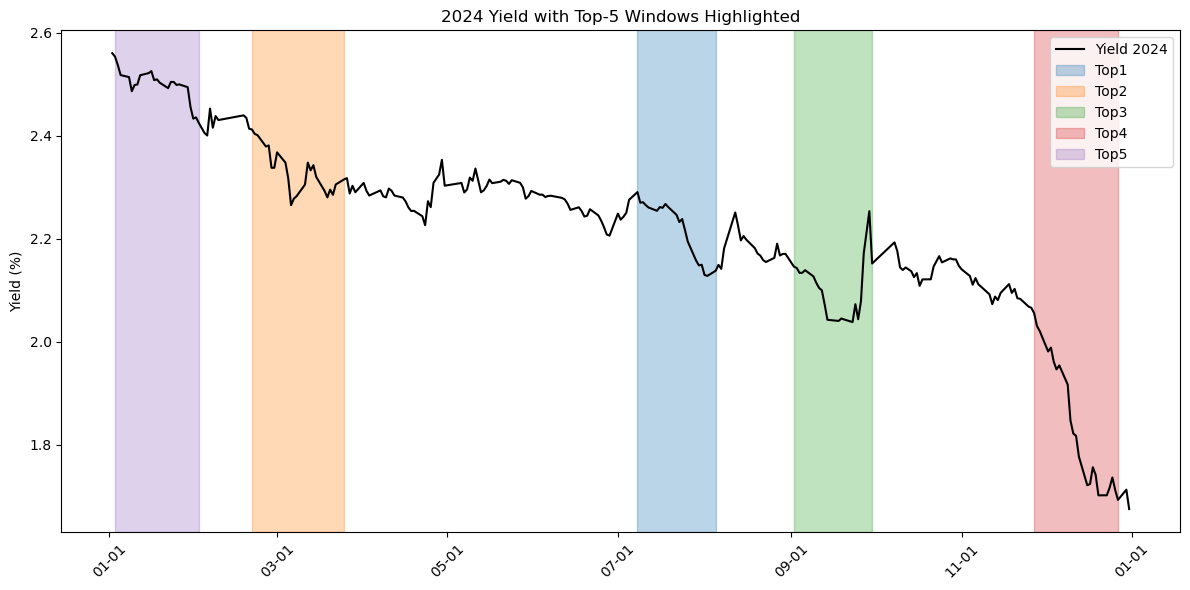

[INFO] 已保存图像: top10_windows_by_length\topn_2024_plot.png


In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas_market_calendars as pmc
from pathlib import Path

# ======== 参数 ========
filtered_path = Path("top10_windows_by_length/all_lengths_rank_by_avg_daily_filtered.xlsx")
DATA_FILE = '中债国债到期收益率_10年.xlsx'
TARGET_YEAR = 2024
TOPN = 5

# ======== 1) 读取数据 & 交易日历 ========
df_raw = pd.read_excel(DATA_FILE)
df_raw['date'] = pd.to_datetime(df_raw['date']).dt.normalize()
df_raw = df_raw.sort_values('date')

# 按年分表
df_by_year = {
    y: g.set_index('date').sort_index()
    for y, g in df_raw.groupby(df_raw['date'].dt.year)
}

# 交易日历
cal = pmc.get_calendar('XSHG')
trade_idx = cal.schedule(start_date='2017-01-01', end_date='2025-12-31').index.normalize()
trade_idx = pd.DatetimeIndex(trade_idx)

def align_to_next_trade_day(ts: pd.Timestamp):
    """对齐到 >= ts 的最近交易日"""
    ts = pd.Timestamp(ts).normalize()
    pos = trade_idx.searchsorted(ts)
    if pos >= len(trade_idx):
        return None
    return trade_idx[pos]

# ======== 2) 取过滤后前 TOPN ========
df_filtered = pd.read_excel(filtered_path, parse_dates=['start_2017', 'end_2017'])
df_topn = df_filtered.head(TOPN).copy()

# ======== 3) 计算 2024 年策略收益 ========
profits_2024 = []
paths_2024 = []

for idx, row in df_topn.iterrows():
    m1, d1 = row['start_2017'].month, row['start_2017'].day
    m2, d2 = row['end_2017'].month, row['end_2017'].day

    # 对齐到交易日
    s_2024 = align_to_next_trade_day(pd.Timestamp(year=TARGET_YEAR, month=m1, day=d1))
    e_2024 = align_to_next_trade_day(pd.Timestamp(year=TARGET_YEAR, month=m2, day=d2))

    if s_2024 is None or e_2024 is None:
        profits_2024.append(None)
        paths_2024.append((None, None))
        continue

    try:
        s_val = df_by_year[TARGET_YEAR].loc[s_2024, 'yield']
        e_val = df_by_year[TARGET_YEAR].loc[e_2024, 'yield']
    except KeyError:
        profits_2024.append(None)
        paths_2024.append((None, None))
        continue

    profit = float(s_val - e_val)  # 注意债券
    profits_2024.append(profit)
    paths_2024.append((s_2024, e_2024))

df_topn['start_2024'] = [p[0] for p in paths_2024]
df_topn['end_2024'] = [p[1] for p in paths_2024]
df_topn['profit_2024'] = profits_2024

# 保存 2024 年收益结果
out_profit_path = Path("top10_windows_by_length/topn_2024_profits.xlsx")
df_topn.to_excel(out_profit_path, index=False)
print(f"[INFO] 已保存 2024 年收益结果: {out_profit_path}")

# ======== 4) 绘制图形 ========
fig, ax = plt.subplots(figsize=(12, 6))

# 画 2024 年收益率折线
df_2024 = df_by_year[TARGET_YEAR].reset_index()
ax.plot(df_2024['date'], df_2024['yield'], color='black', label='Yield 2024')

# 给每个区间一个颜色
colors = plt.cm.tab10.colors  # 10 种颜色
for i, (start, end) in enumerate(paths_2024):
    if start is None or end is None:
        continue
    ax.axvspan(start, end, color=colors[i % len(colors)], alpha=0.3, label=f"Top{i+1}")

# X轴格式：只显示月日
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.xticks(rotation=45)
ax.set_title(f"2024 Yield with Top-{TOPN} Windows Highlighted")
ax.set_ylabel("Yield (%)")
ax.legend()
plt.tight_layout()

out_plot_path = Path("top10_windows_by_length/topn_2024_plot.png")
plt.savefig(out_plot_path, dpi=150)
plt.show()
print(f"[INFO] 已保存图像: {out_plot_path}")